# H.4] Imaginary Time Evolution
d) Numerically integrate random initial state up to certain time $\tau_{\text{max}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix
from scipy.linalg import expm, eigh
from scipy.sparse.linalg import expm_multiply

In [2]:
def random_initial_state(L):
    psi = np.random.randn(2**L) + 1j*np.random.randn(2**L)
    return psi / np.linalg.norm(psi)

In [3]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, site, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[site] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_site_operators(operator, L):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, L) for j in range(L)]

In [4]:
def transverse_field_ising_hamiltonian(h, J, L, eps=0.0, sparse=True):
    dtype = np.complex128
    H = csr_matrix((2**L, 2**L), dtype=dtype)
    sx_list = all_site_operators(sigma_x, L)
    sz_list = all_site_operators(sigma_z, L)

    for i in range(L - 1):
        H += -J * (sz_list[i] @ sz_list[i+1])
    for sx in sx_list:
        H += -h * sx
    for sz in sz_list:
        H += -eps * sz

    return H if sparse else H.toarray()

In [5]:
def compute_ground_overlap(psi, H_dense):
    eigvals, eigvecs = eigh(H_dense)
    delta = np.abs(eigvals[1] - eigvals[0])

    if delta < 1e-10:
        v1, v2 = eigvecs[:, 0], eigvecs[:, 1]
        proj = np.abs(np.vdot(v1, psi))**2 + np.abs(np.vdot(v2, psi))**2
        print(f"Warning: Ground state degeneracy detected. Delta = {delta:.2e}")
    else:
        v1 = eigvecs[:, 0]
        proj = np.abs(np.vdot(v1, psi))**2
    return proj

In [6]:
# Parameters
L = 4
T = 10.0
h, J = 2.0, 1.0
timesteps = 100
times = np.linspace(0, T, timesteps)
dt = times[1] - times[0]

# Initial state and normalization
psi = np.random.randn(2**L) + 1j*np.zeros(2**L)
psi /= np.linalg.norm(psi) 

energies = []
overlaps = []

for t in times[:]:
    H_sparse = transverse_field_ising_hamiltonian(h, J, L)
    H_dense = H_sparse.toarray()
    
    energy = np.real(psi.conj().T @ H_dense @ psi)
    energies.append(energy)

    overlaps.append(compute_ground_overlap(psi, H_dense))
    
    psi = expm_multiply(-H_sparse * dt, psi)
    psi /= np.linalg.norm(psi)

e) Monitor convergence to ground state energy

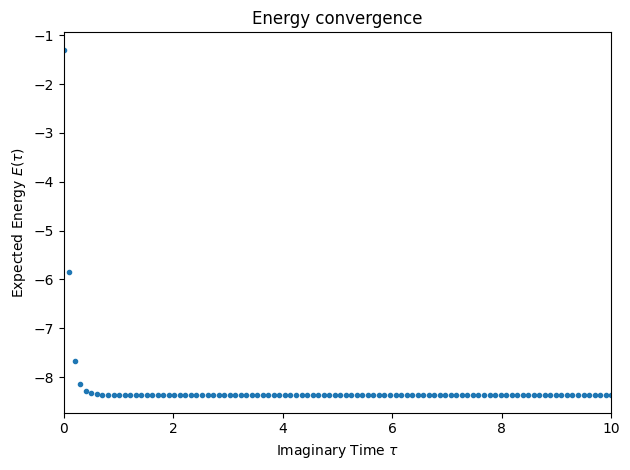

In [7]:
# Plot energy expectation value over time tau
plt.scatter(times, energies, marker='.')

plt.xlabel(r'Imaginary Time $\tau$')
plt.ylabel(r'Expected Energy $E(\tau)$')
plt.title('Energy convergence')
plt.xlim(times[0], times[-1])

plt.tight_layout()
plt.show()

f) Check if ITP ground state is correct

In [8]:
ITP_groundstate = psi
H_dense = transverse_field_ising_hamiltonian(h, J, L).toarray()
exact_energies, exact_eigenstates = eigh(H_dense)

print("Final overlap of ground state obtained with ITP and ed ground state: ", overlaps[-1]) # overlaps vary depending on overlap of random initial state with the true ground state

print("ED ground state energy: ", exact_energies[0])
print("ITP ground state energy: ", energies[-1])

Final overlap of ground state obtained with ITP and ed ground state:  1.0
ED ground state energy:  -8.376798636850362
ITP ground state energy:  -8.37679863685036


g) Compare efficiency of ITP vs real-time adiabatic evolution

The main cost occurs in the integration, which uses the RK45 method. Depending on the initial overlap with the true ground state, the ITP method requires around 1000 time steps to find a wavefunction overlapping with the ground state by ~99.99%. However, for some initial random states the resulting overlap reaches lower values. The adiabatic search requires many more time steps in the integration in order to evolve slowly enough to not leave the ground state. However, a comparison of efficiency is difficult, since the result of the adiabatic search does not match the eigenstate obtained with exact diagonalization. 

Additionally, the adiabatic search starts in a ground state with considerable overlap with the ground state of interest. The ITP method might lead to constantly reliable results if it would follow the same procedure. Also, other integration methods (e.g. computationally cheaper ones, like Euler's method) might work better for the time grid of adiabatic search than for the one of imaginary time propagation.

### Run for multiple different initial states

In [9]:
h, J, L = 2.0, 1.0, 4

# Parameters
T = 10.0
timesteps = 100
times = np.linspace(0, T, timesteps)
dt = times[1] - times[0]
iterations = 200

final_overlaps = []
final_gs_energies = []

for i in range(iterations):
    # Initial state and normalization
    psi = random_initial_state(L)
    H_sparse = transverse_field_ising_hamiltonian(h, J, L)
    H_dense = H_sparse.toarray()

    for t in times:
        psi = expm_multiply(-H_sparse * dt, psi)
        psi /= np.linalg.norm(psi)

        if t == times[-1]:
            energy = np.real(psi.conj().T @ H_dense @ psi)
            final_gs_energies.append(energy)
            final_overlaps.append(compute_ground_overlap(psi, H_dense))

In [10]:
print(f'Final ground state overlaps for {iterations} iterations:')
unique_overlaps = np.unique(final_overlaps, return_counts=True)
for i in range(len(unique_overlaps[0])):
    print(f'Overlap {unique_overlaps[0][i]} calculated {unique_overlaps[1][i]} times')

print('')
print(f'Final ground state energies for {iterations} iterations')
unique_energies = np.unique(final_gs_energies, return_counts=True)
for i in range(len(unique_energies[0])):
    print(f'Energy {unique_energies[0][i]} calculated {unique_energies[1][i]} times')


Final ground state overlaps for 200 iterations:
Overlap 0.9999999999999996 calculated 1 times
Overlap 0.9999999999999998 calculated 4 times
Overlap 1.0 calculated 63 times
Overlap 1.0000000000000004 calculated 127 times
Overlap 1.0000000000000009 calculated 5 times

Final ground state energies for 200 iterations
Energy -8.376798636850364 calculated 6 times
Energy -8.376798636850362 calculated 61 times
Energy -8.37679863685036 calculated 107 times
Energy -8.376798636850358 calculated 22 times
Energy -8.376798636850356 calculated 4 times


### Will numerically integration of the imaginary time SE yield the same result?

In [52]:
# Define derivative using imaginary time SEQ
def dpsi_dtau(t, psi, h=2, J=1):
    psi = psi.view(dtype=np.complex128) / np.linalg.norm(psi.view(dtype=np.complex128))
    return (-transverse_field_ising_hamiltonian(h, J, L) @ psi).view(dtype=np.float64) 

# inital state and parameters
psi0 = random_initial_state(L)
T = 20.0
timesteps = 1000
times = np.linspace(0, T, timesteps)

# Numerically integrate this state
sol = solve_ivp(dpsi_dtau, t_span = (0, T), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, T, timesteps))

# Normalize wave functions of each step dt
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)   # copy to ensure that the memory is laid out contiguously before using changing the data type to complex128

# note: normalization should take place in every step here, however it does not
print(f'Initial state has norm {np.linalg.norm(psi_tau_list[0])} and final state has norm {np.linalg.norm(psi_tau_list[-1]):.2f}.')

# normalize here
psi_tau_normalized = np.array([psi / np.linalg.norm(psi) for psi in psi_tau_list])

Initial state has norm 1.0000000000000002 and final state has norm 165.33.


In [53]:
overlaps = np.array([compute_ground_overlap(psi, H_dense) for psi in psi_tau_normalized])
energies = np.array([np.real(psi.conj().T @ H_dense @ psi) for psi in psi_tau_normalized])

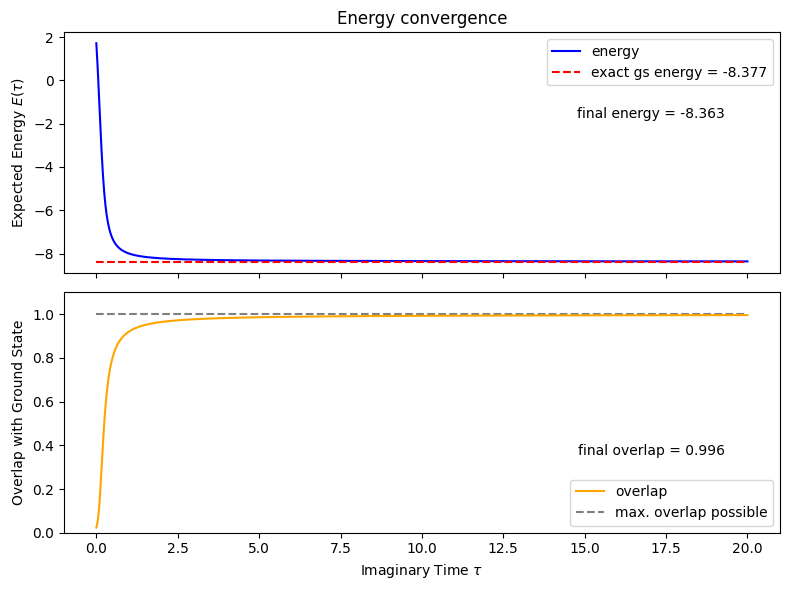

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax[0].plot(times, energies, label='energy', color='blue')
ax[0].hlines(y=exact_energies[0], xmin=times[0], xmax=times[-1], color='red', linestyle='--', label='exact gs energy = {:.3f}'.format(exact_energies[0]))
ax[0].text(0.82, 0.66, rf'final energy = {energies[-1]:.3f}', fontsize=10, ha='center', va='center', color='black', zorder=0, transform=ax[0].transAxes)

ax[0].set_ylabel(r'Expected Energy $E(\tau)$')
ax[0].set_title('Energy convergence')
ax[0].legend()

ax[1].plot(times, overlaps, label='overlap', color='orange', zorder=1)
ax[1].hlines(y=1., xmin=times[0], xmax=times[-1], color='gray', linestyle='--', label='max. overlap possible', zorder=0)
ax[1].text(0.82, 0.34, rf'final overlap = {overlaps[-1]:.3f}', fontsize=10, ha='center', va='center', color='black', zorder=0, transform=ax[1].transAxes)

ax[1].set_ylim(0, 1.1)
ax[1].set_xlabel(r'Imaginary Time $\tau$')
ax[1].set_ylabel(r'Overlap with Ground State')
ax[1].legend(loc='lower right')

plt.tight_layout()